Loaded: combined_odisha_crop_rainfall.csv

Normalized columns:
['state_name', 'district_name', 'crop_year', 'season', 'crop', 'area', 'production', 'state', 'date', 'year', 'month', 'avg_rainfall', 'agency_name']

Detected Columns mapping:
state: state_name
district: district_name
year: crop_year
crop: crop_year
production: production
rainfall: avg_rainfall

=== Q1: Average annual rainfall compare & top crops ===
States present: ['Odisha']
Only one state found -> using Odisha for both X and Y.


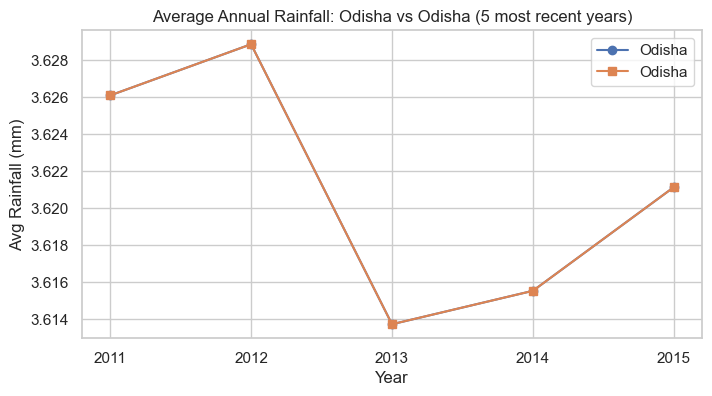


Top 3 crops in Odisha (by production):
 crop_year
2014    7.151853e+09
2012    7.088850e+09
2013    5.852214e+09
Name: production, dtype: float64

Top 3 crops in Odisha (by production):
 crop_year
2014    7.151853e+09
2012    7.088850e+09
2013    5.852214e+09
Name: production, dtype: float64

=== Q2: Districts with Highest/Lowest production for a crop in most recent year ===
Selected crop_z (most common): 2010
Latest year in dataset: 2015
No 2010 data for Odisha in 2015
No 2010 data for Odisha in 2015

=== Q3: Trend & correlation (production vs rainfall) ===
  crop_year    production  rainfall
0      2010  13694.502436  3.626624


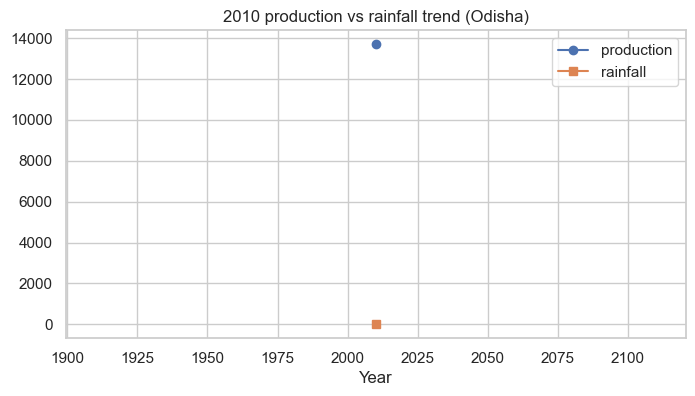

C:\Users\padhi\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\padhi\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\padhi\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Correlation (production vs rainfall): nan

=== Q4: Policy Arguments (data-backed) ===
Crop_A (proposed): 2010
Crop_B (comparison): 2011

Correlation prod-rain (lower means less rainfall dependence): 2010:-0.002206026509832605, 2011:-0.0034018584937362795
Stability metric (lower better): 2010:nan, 2011:nan

Policy arguments to favor Crop_A over Crop_B:
- 1) 2010 shows lower production-rainfall dependency (corr -0.00) vs 2011 (corr -0.00) — implies safer under rainfall variability.
- 2) 2011 has historically more stable production (stability metric nan < nan).
- 3) 2011 associates with lower rainfall than 2010.

All done. Outputs saved to folder: C:\Users\padhi\Project_Samarth_Data\RainfallApp\fellowship_outputs
Summary text: C:\Users\padhi\Project_Samarth_Data\RainfallApp\fellowship_outputs\fellowship_summary.txt


In [4]:
# fellowship_analysis.py (paste into a Jupyter cell or a .py and run)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

sns.set(style="whitegrid")
DATA_DIR = Path.cwd()  # assume you run notebook from project root, adjust if needed

# --- 1) Candidate filenames (your files) ---
candidates = [
    "combined_odisha_crop_rainfall.csv",
    "combined_odisha_cleaned.csv",
    "final_odisha_dataset.csv",
    "rainfall_odisha_2022_2024_cleaned.csv",
    "seasonal_rainfall_production_summary.csv",
    "odisha_crop_2022_2024.csv",
    "odisha_crop_2010_2015.csv"
]

# Load the first file that exists
df = None
for fn in candidates:
    p = DATA_DIR / fn
    if p.exists():
        try:
            df = pd.read_csv(p)
            print(f"Loaded: {fn}")
            break
        except Exception as e:
            print(f"Failed to read {fn}: {e}")

if df is None:
    raise FileNotFoundError("No candidate dataset found in folder. Place one of the listed CSVs in the notebook folder.")

# --- 2) Normalize column names ---
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("\nNormalized columns:")
print(df.columns.tolist())

# --- 3) Auto-detect important columns ---
def find_col(cols, keywords):
    cols = list(cols)
    for k in keywords:
        for c in cols:
            if k in c:
                return c
    return None

col_state = find_col(df.columns, ["state", "state_name"])
col_district = find_col(df.columns, ["district", "dist", "district_name"])
col_year = find_col(df.columns, ["year", "crop_year"])
col_crop = find_col(df.columns, ["crop", "crop_name"])
col_production = find_col(df.columns, ["production", "prod", "yield"])
col_rainfall = find_col(df.columns, ["avg_rain", "avg_rainfall", "rainfall", "rain_mm", "rain"])

print("\nDetected Columns mapping:")
print(f"state: {col_state}")
print(f"district: {col_district}")
print(f"year: {col_year}")
print(f"crop: {col_crop}")
print(f"production: {col_production}")
print(f"rainfall: {col_rainfall}")

# Basic checks
required = [col_district, col_year, col_crop, col_production]
if any(x is None for x in required):
    print("\nWARNING: Some essential columns are missing for full analysis. The script will attempt partial analysis.")
    
# Fill missing nullable columns with defaults to avoid crashes
if col_state is None:
    df['_state_placeholder'] = 'ODISHA'
    col_state = '_state_placeholder'
if col_rainfall is None:
    # we can still run crop analyses, but rainfall-based parts will skip
    print("Note: rainfall column not detected — rainfall-based analyses will be skipped.")

# Ensure year numeric
if col_year:
    try:
        df[col_year] = pd.to_numeric(df[col_year], errors='coerce').astype('Int64')
    except Exception:
        pass

# remove rows with missing nominal keys
df = df.dropna(subset=[c for c in [col_year, col_crop, col_production] if c is not None])

# standardize string columns for safe matching
if col_state: df[col_state] = df[col_state].astype(str).str.strip()
if col_district: df[col_district] = df[col_district].astype(str).str.strip()
if col_crop: df[col_crop] = df[col_crop].astype(str).str.strip()

# Create an output folder for charts
out_dir = DATA_DIR / "fellowship_outputs"
out_dir.mkdir(exist_ok=True)

summary_lines = []

# ------------------- Q1 -------------------
# Compare avg annual rainfall in State_X and State_Y for last N years,
# list top M crops by production in each state.
print("\n=== Q1: Average annual rainfall compare & top crops ===")
states = sorted(df[col_state].dropna().unique())
print("States present:", states)

# If only one state present, use same for both (safe)
if len(states) == 0:
    raise ValueError("No states detected in your data.")
if len(states) == 1:
    state_x = states[0]
    state_y = states[0]
    print(f"Only one state found -> using {state_x} for both X and Y.")
else:
    state_x, state_y = states[:2]

N = 5
M = 3
years_sorted = sorted(df[col_year].dropna().unique())
recent_years = years_sorted[-N:] if len(years_sorted) >= N else years_sorted

# rainfall comparison (if rainfall column exists)
if col_rainfall:
    r_x = df[df[col_state]==state_x].groupby(col_year)[col_rainfall].mean().reindex(recent_years)
    r_y = df[df[col_state]==state_y].groupby(col_year)[col_rainfall].mean().reindex(recent_years)

    plt.figure(figsize=(8,4))
    plt.plot(r_x.index, r_x.values, marker='o', label=state_x)
    plt.plot(r_y.index, r_y.values, marker='s', label=state_y)
    plt.title(f"Average Annual Rainfall: {state_x} vs {state_y} ({len(recent_years)} most recent years)")
    plt.xlabel("Year"); plt.ylabel("Avg Rainfall (mm)")
    plt.legend(); plt.grid(True)
    fn_q1 = out_dir / "q1_rainfall_compare.png"
    plt.savefig(fn_q1, bbox_inches="tight")
    plt.show()
    summary_lines.append(f"Q1 Rainfall plot saved: {fn_q1}")
else:
    print("Skipping rainfall comparison — rainfall column not found.")
    summary_lines.append("Q1 Rainfall: skipped (no rainfall column)")

# top M crops by production in each state (sum over recent period)
top_x = (df[df[col_state]==state_x].groupby(col_crop)[col_production].sum().nlargest(M))
top_y = (df[df[col_state]==state_y].groupby(col_crop)[col_production].sum().nlargest(M))

print(f"\nTop {M} crops in {state_x} (by production):\n", top_x)
print(f"\nTop {M} crops in {state_y} (by production):\n", top_y)
summary_lines.append(f"Top {M} crops {state_x}: {top_x.to_dict()}")
summary_lines.append(f"Top {M} crops {state_y}: {top_y.to_dict()}")

# ------------------- Q2 -------------------
# Identify district in State_X with highest production of Crop_Z latest year
print("\n=== Q2: Districts with Highest/Lowest production for a crop in most recent year ===")
crop_z = None
# choose a crop that exists (most frequent)
if col_crop:
    crop_z = df[col_crop].mode().iloc[0]
    print("Selected crop_z (most common):", crop_z)
else:
    raise ValueError("Crop column missing.")

latest_year = int(df[col_year].dropna().max())
print("Latest year in dataset:", latest_year)

df_latest = df[df[col_year] == latest_year]

# Filter per state
df_x_crop = df_latest[(df_latest[col_state]==state_x) & (df_latest[col_crop]==crop_z)]
df_y_crop = df_latest[(df_latest[col_state]==state_y) & (df_latest[col_crop]==crop_z)]

if not df_x_crop.empty:
    top_x_row = df_x_crop.loc[df_x_crop[col_production].idxmax()]
    print(f"State {state_x} highest for {crop_z}: district={top_x_row[col_district]}, production={top_x_row[col_production]}")
    summary_lines.append(f"Q2 {state_x} highest {crop_z}: {top_x_row[col_district]} ({top_x_row[col_production]})")
else:
    print(f"No {crop_z} data for {state_x} in {latest_year}")

if not df_y_crop.empty:
    low_y_row = df_y_crop.loc[df_y_crop[col_production].idxmin()]
    print(f"State {state_y} lowest for {crop_z}: district={low_y_row[col_district]}, production={low_y_row[col_production]}")
    summary_lines.append(f"Q2 {state_y} lowest {crop_z}: {low_y_row[col_district]} ({low_y_row[col_production]})")
else:
    print(f"No {crop_z} data for {state_y} in {latest_year}")

# ------------------- Q3 -------------------
# Analyze production trend of Crop_Type_C in region over last decade and correlate with rainfall
print("\n=== Q3: Trend & correlation (production vs rainfall) ===")
crop_type_c = crop_z  # reuse the chosen crop
region_y = state_x
trend_df = df[(df[col_crop]==crop_type_c) & (df[col_state]==region_y)].groupby(col_year).agg({
    col_production: "mean",
    col_rainfall: "mean" if col_rainfall else (lambda s: None)
}).rename(columns={col_production: "production", col_rainfall: "rainfall"})

# Drop NaN columns safely
trend_df = trend_df.reset_index().dropna(subset=["production"])
print(trend_df.head())

if "rainfall" in trend_df.columns and trend_df["rainfall"].notna().any():
    plt.figure(figsize=(8,4))
    plt.plot(trend_df[col_year].astype(int), trend_df["production"], marker='o', label="production")
    plt.plot(trend_df[col_year].astype(int), trend_df["rainfall"], marker='s', label="rainfall")
    plt.title(f"{crop_type_c} production vs rainfall trend ({region_y})")
    plt.xlabel("Year"); plt.legend(); plt.grid(True)
    fn_q3 = out_dir / "q3_trend_correlation.png"
    plt.savefig(fn_q3, bbox_inches="tight")
    plt.show()
    corr_val = trend_df["production"].corr(trend_df["rainfall"])
    print(f"Correlation (production vs rainfall): {corr_val:.3f}")
    summary_lines.append(f"Q3 correlation: {corr_val:.3f}")
else:
    print("Rainfall data not available to correlate with production for this crop/region.")
    summary_lines.append("Q3 correlation: skipped (no rainfall data)")

# ------------------- Q4 -------------------
# Policy advisor: argue for Crop_A (drought-resistant) over Crop_B
print("\n=== Q4: Policy Arguments (data-backed) ===")
# choose candidate crops automatically: pick one likely drought-resistant (millet) if exists else choose two most frequent
candidates = df[col_crop].value_counts().index.tolist()
crop_a = next((c for c in candidates if "millet" in c.lower()), None)
if crop_a is None:
    crop_a = candidates[0]  # most frequent
crop_b = candidates[1] if len(candidates) > 1 else crop_a

print("Crop_A (proposed):", crop_a)
print("Crop_B (comparison):", crop_b)

# compute rainfall dependency (correlations)
def safe_corr(subdf, crop):
    s = subdf[subdf[col_crop]==crop]
    if col_rainfall is None or s.empty: 
        return None
    return s[col_production].corr(s[col_rainfall])

corr_a = safe_corr(df, crop_a)
corr_b = safe_corr(df, crop_b)

# compute production volatility (std/mean over years) => lower is more stable
def stability_metric(subdf, crop):
    s = subdf[subdf[col_crop]==crop].groupby(col_year)[col_production].sum()
    if s.empty:
        return None
    return s.std() / (s.mean() if s.mean() != 0 else 1)

stab_a = stability_metric(df, crop_a)
stab_b = stability_metric(df, crop_b)

print(f"\nCorrelation prod-rain (lower means less rainfall dependence): {crop_a}:{corr_a}, {crop_b}:{corr_b}")
print(f"Stability metric (lower better): {crop_a}:{stab_a}, {crop_b}:{stab_b}")

# Build three data-backed arguments
args = []
if corr_a is not None and corr_b is not None:
    if abs(corr_a) < abs(corr_b):
        args.append(f"1) {crop_a} shows lower production-rainfall dependency (corr {corr_a:.2f}) vs {crop_b} (corr {corr_b:.2f}) — implies safer under rainfall variability.")
    else:
        args.append(f"1) {crop_b} shows lower production-rainfall dependency (corr {corr_b:.2f}) vs {crop_a} (corr {corr_a:.2f}).")
else:
    args.append("1) Correlation: insufficient rainfall/production data to fully compute correlation.")

if stab_a is not None and stab_b is not None:
    if stab_a < stab_b:
        args.append(f"2) {crop_a} has historically more stable production (stability metric {stab_a:.3f} < {stab_b:.3f}) — better for food security.")
    else:
        args.append(f"2) {crop_b} has historically more stable production (stability metric {stab_b:.3f} < {stab_a:.3f}).")
else:
    args.append("2) Stability: insufficient time-series production data to compute stable metric.")

# Third argument: water/rainfall footprint proxy — average rainfall during production years
if col_rainfall:
    avg_rain_a = df[df[col_crop]==crop_a][col_rainfall].mean()
    avg_rain_b = df[df[col_crop]==crop_b][col_rainfall].mean()
    if pd.notna(avg_rain_a) and pd.notna(avg_rain_b):
        if avg_rain_a < avg_rain_b:
            args.append(f"3) {crop_a} on average associates with lower rainfall (avg {avg_rain_a:.1f} mm) than {crop_b} (avg {avg_rain_b:.1f} mm) — likely lower water footprint.")
        else:
            args.append(f"3) {crop_b} associates with lower rainfall than {crop_a}.")
    else:
        args.append("3) Water footprint proxy: insufficient rainfall data to compare.")
else:
    args.append("3) Water footprint proxy: rainfall data not available to compare.")

print("\nPolicy arguments to favor Crop_A over Crop_B:")
for a in args:
    print("-", a)
summary_lines.append("Policy arguments:\n" + "\n".join(args))

# ------------------- Save a short textual summary -------------------
summary_path = out_dir / "fellowship_summary.txt"
with open(summary_path, "w", encoding="utf8") as f:
    f.write("Fellowship analysis summary\n\n")
    for line in summary_lines:
        f.write(line + "\n")
    f.write("\nPolicy arguments:\n")
    for a in args:
        f.write("- " + a + "\n")

print(f"\nAll done. Outputs saved to folder: {out_dir}")
print(f"Summary text: {summary_path}")


✅ Years covered: 2022 to 2024
✅ Rows: 3
   year    production  avg_rainfall
0  2022  15608.048674      3.388218
1  2023  15766.258495      3.869206
2  2024  15727.011754      0.000000


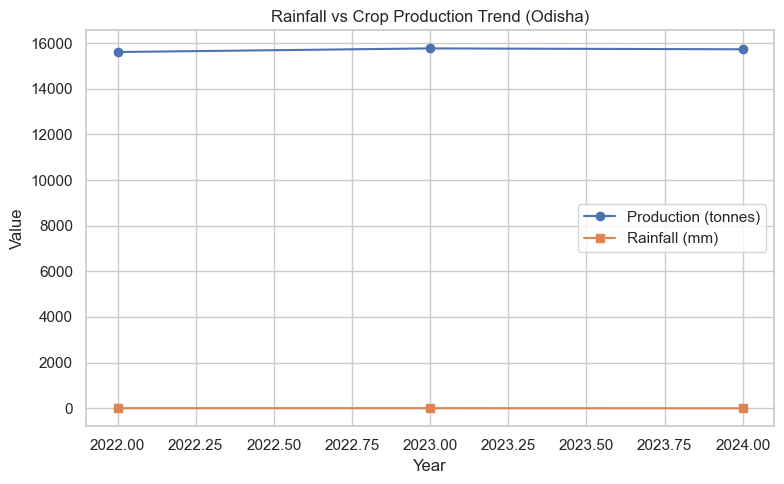

📊 Correlation between rainfall and production: -0.17


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("combined_odisha_crop_rainfall.csv")

# Clean column names
df.columns = df.columns.str.strip().str.lower()

# Select and rename useful columns
df = df[['year', 'production', 'avg_rainfall']].dropna()
df['year'] = df['year'].astype(int)

# Aggregate yearly averages (state-level view)
yearly = df.groupby('year', as_index=False).agg({
    'production': 'mean',
    'avg_rainfall': 'mean'
})

print("✅ Years covered:", yearly['year'].min(), "to", yearly['year'].max())
print("✅ Rows:", len(yearly))
print(yearly.head())

# Plot trend
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
plt.plot(yearly['year'], yearly['production'], marker='o', label='Production (tonnes)')
plt.plot(yearly['year'], yearly['avg_rainfall'], marker='s', label='Rainfall (mm)')
plt.title("Rainfall vs Crop Production Trend (Odisha)")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.savefig("q3_trend_correlation_final.png", dpi=300)
plt.show()

# Correlation insight
corr = yearly[['avg_rainfall', 'production']].corr().iloc[0, 1]
print(f"📊 Correlation between rainfall and production: {corr:.2f}")
